# Multipath Fading

In this chapter we introduce multipath, a propagation phenomenon that results in signals reaching the receiver by two or more paths, which we experience in real-world wireless systems. So far we have only discussed the “AWGN Channel”, i.e., a model for a wireless channel where the signal is simply added to noise, which really only applies to signals over a cable and some satellite communications systems.

# Simulating Rayleigh Fading

Rayleigh fading is used to model fading over time, when there is no significant LOS path. When there is a dominant LOS path, the Rician fading model becomes more suitable, but we will be focusing on Rayleigh. Note that Rayleigh and Rician models do not include the primarily path loss between the transmitter and receiver (such as the path loss calculated as part of a link budget), or any shadowing caused by large objects. Their role is to model the multipath fading that occurs over time, as a result of movement and scatterers in the environment.

There is a lot of theory that comes out of the Rayleigh fading model, such as expressions for level crossing rate and average fade duration. But the Rayleigh fading model doesn’t directly tell us how to actually simulate a channel using the model. To generate Rayleigh fading in simulation we have to use one of many published methods, and in the following Python example we will be using Clarke’s “sum-of-sinusoids” method.

To generate a Rayleigh fading channel in Python we need to first specify the max Doppler shift, in Hz, which is based on how fast the transmitter and/or receiver is moving, denoted \Delta v. When the velocity is small compared to the speed of light, which will always be the case in wireless communications, the Doppler shift can be calculated as:



![Alt text](https://pysdr.org/_images/math/33082a944cabaeeb7f8830b2d0ca8936ace4a7cc.svg)




We also choose how many sinusoids to simulate, and there’s no right answer because it’s based on the number of scatterers in the environment, which we never actually know. As part of the calculations we assume the phase of the received signal from each path is uniformly random between 0 and 2\pi. The following code simulates a Rayleigh fading channel using Clarke’s method:

Max Doppler shift: 17.881555555555558


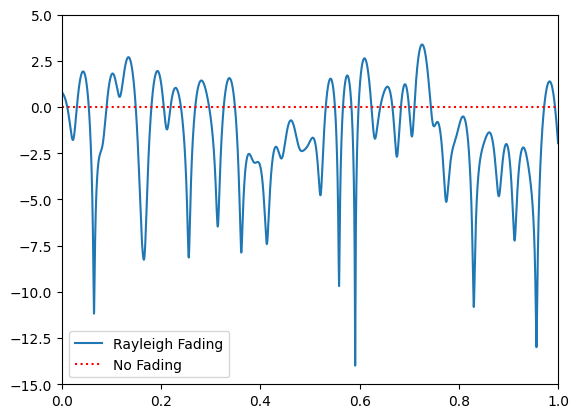

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation param
v_mph = 60  # velocity of RT/TX
Fc = 200e6  # RF carrier freq (center freq)
Fs = 1e5    # Sample rate of simulation
N = 100     # Num of sinusiods to sum

v = v_mph*(1609.34)*(1/60)*(1/60) # Convert to m/s
fd = v*Fc/3e8
print("Max Doppler shift: "+str(fd))
t = np.arange(0, 1, 1/Fs) # time vector. (start, stop, step)
x = np.zeros(len(t))
y = np.zeros(len(t))

for i in range(N):
    alpha = (np.random.rand() - 0.5) * 2 * np.pi
    phi = (np.random.rand() - 0.5) * 2 * np.pi
    x = x + np.random.randn() * np.cos(2 * np.pi * fd * t * np.cos(alpha) + phi)
    y = y + np.random.randn() * np.sin(2 * np.pi * fd * t * np.cos(alpha) + phi)

# z is the complex coefficient representing channel, you can think of this as a phase shift and magnitude scale
z = (1/np.sqrt(N)) * (x + 1j*y) # this is what you would actually use when simulating the channel
z_mag = np.abs(z) # take magnitude for the sake of plotting
z_mag_dB = 10*np.log10(z_mag) # convert to dB

# Plot fading over time
plt.plot(t, z_mag_dB)
plt.plot([0, 1], [0, 0], ':r') # 0 dB
plt.legend(['Rayleigh Fading', 'No Fading'])
plt.axis([0, 1, -15, 5])
plt.show()

# Mitigating Multipath Fading¶

## CDMA 

3G cellular uses a technology called code division multiple access (CDMA). With CDMA you take a narrowband signal and spread it over a wide bandwidth before transmitting it (using a spread spectrum technique called DSSS). Under frequency selective fading, it’s unlikely that all frequencies will be in a deep null at the same time. At the receiver the spreading is reversed, and this de-spreading process greatly mitigates a deep null.

![Alt text](https://pysdr.org/_images/cdma.png)

## OFDM 

4G cellular, WiFi, and many other technologies use a scheme called orthogonal frequency-division multiplexing (OFDM). OFDM uses something called subcarriers, where we split up the signal in the frequency domain into a bunch of narrow signals squashed together. To combat multipath fading we can avoid assigning data to subcarriers that are in a deep fade, although it requires the receiving end to send channel information back to the transmitter quick enough. We can also assign high order modulation schemes to subcarriers with great channel quality to maximize our data rate.